# Hands-on Lab --- Calculating and Analyzing CLV

## Importing standard packages:

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## Reading in the original data, and joining with the churn and margin predicted values:

In [2]:
combined_df = pd.read_csv(r'C:\MSBAN\Fall 2019\clv\combined_data.csv')
churn_df = pd.read_csv(r'C:\MSBAN\Fall 2019\clv\churn_scores.csv')
margin_df = pd.read_csv(r'C:\MSBAN\Fall 2019\clv\margin_scores.csv')

combined_df = pd.merge(combined_df, churn_df, on='acct_ID', how='left')
combined_df = pd.merge(combined_df, margin_df, on='acct_ID', how='left')

# it should be noted that Python is case sensitive for variable names.  acct_id above would fail.

combined_df.shape

(73384, 113)

## Since our margin model had transformed the target variable, we need to untransform the predicted value,
##     using the inverse of our transformation:

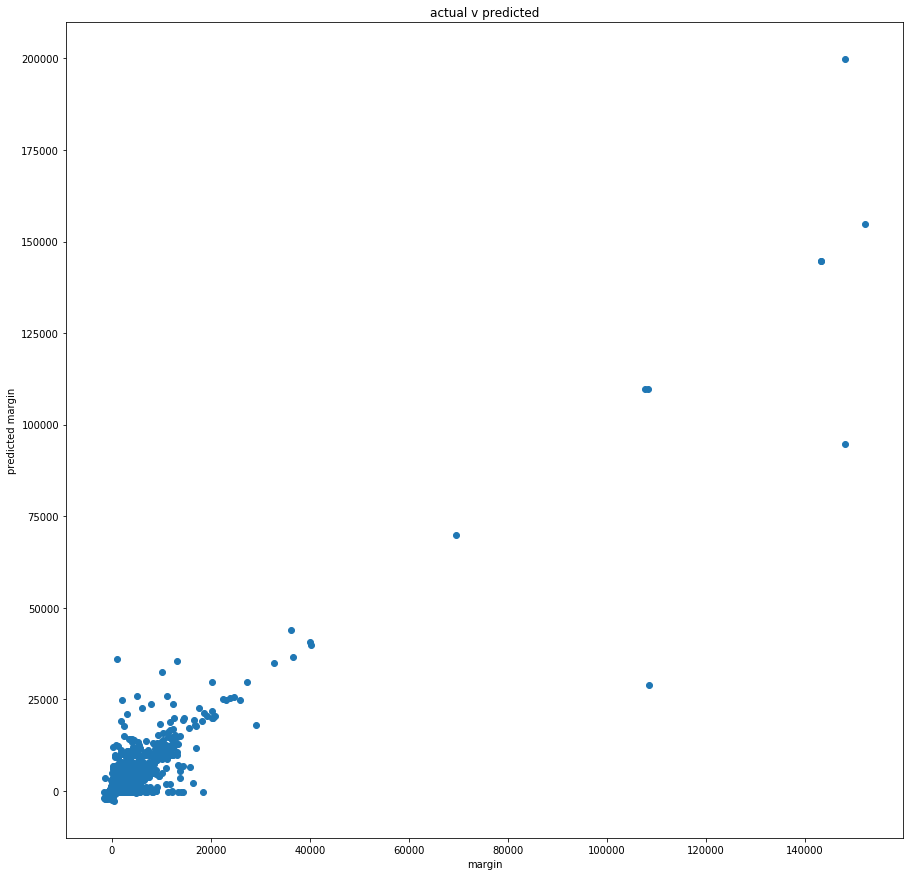

In [3]:
combined_df['P_margin_Y_pos_1']=10**combined_df['P_log_margin_Y_pos_1']-50000

# Plotting predicted untransformed values vs actual untransformed values:

plt.figure(figsize=(15,15))
plt.scatter(combined_df['P_margin_Y_pos_1'], combined_df['margin_Y_pos_1'])
plt.xlabel("margin")
plt.ylabel("predicted margin")
plt.title("actual v predicted")
# plt.xticks([])
# plt.yticks([])
print(" ") 
plt.show()

# It should be noted:  we are scoring our original data, used for modeling, only for the purposes of analysis.
##  In a "real world" situation, we would most likely be scoring a full population for which we did not actually
##  know the future churn or the future margin.

## We are using a simplified CLV formula, in which we:
###    *  are predicting only annual numbers,
###    *  are assuming that next year's annual prediction are the same values for the next 3 years,
###    *  that our future value is adequately estimated using only 3 future years.

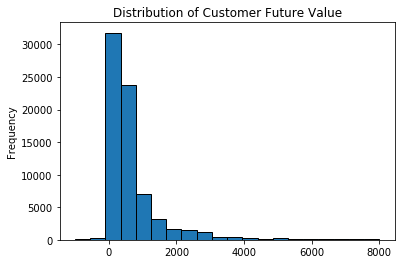

,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,log_purch_cnt_life,log_purch_cnt_tt_36mo,log_resp_cnt_36mo,perc_purch_cc_36mo,perc_purch_ck_36mo,perc_purch_et_36mo,margin_Y_neg_1,margin_Y_neg_2,margin_Y_neg_3,...,ST_TX,ST_UT,ST_VA,ST_VI,ST_VT,ST_WA,ST_WI,ST_WV,ST_WY,ST_missing,tier_1-Bronze,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx,P_churn_year_plus1_ind,P_log_margin_Y_pos_1,P_margin_Y_pos_1,CFV
count,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,...,73384.00,7.34e+04,73384.00,7.34e+04,7.34e+04,73384.00,73384.00,7.34e+04,7.34e+04,7.34e+04,73384.00,73384.0,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,73384.00,7.34e+04,73384.00,7.34e+04,7.34e+04,73384.00,73384.00
mean,0.52,0.89,0.96,0.09,0.26,2.91,65.34,4.85,19.05,7.76,2.27,0.26,0.74,2.61,2.86,1.54,1.40,1.14,0.33,0.31,0.56,0.13,229.17,194.19,158.83,...,0.09,1.42e-03,0.04,2.59e-04,7.36e-04,0.03,0.01,8.54e-03,2.02e-03,4.05e-03,0.64,0.2,0.11,0.02,0.02,0.21,0.06,0.03,0.01,6.05e-03,0.68,2.63e-01,4.70e+00,416.33,818.50
std,0.50,0.31,0.19,0.29,0.44,3.10,58.06,9.95,14.81,45.59,2.37,0.44,0.29,0.65,0.79,0.35,0.60,0.43,0.45,0.44,0.47,0.32,1591.28,1697.65,1393.69,...,0.28,3.76e-02,0.20,1.61e-02,2.71e-02,0.16,0.11,9.20e-02,4.49e-02,6.35e-02,0.48,0.4,0.32,0.15,0.14,0.41,0.24,0.18,0.10,7.75e-02,0.47,3.18e-01,8.96e-03,1654.24,3390.24
min,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,-18624.22,-7675.16,-6902.63,...,0.00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00,4.08e-03,4.69e+00,-1569.35,-3330.93
25%,0.00,1.00,1.00,0.00,0.00,1.00,14.00,1.00,6.00,0.00,1.00,0.00,0.60,2.21,2.34,1.32,0.95,0.85,0.00,0.00,0.00,0.00,43.15,0.00,0.00,...,0.00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00,1.30e-02,4.70e+00,150.12,115.96
50%,1.00,1.00,1.00,0.00,0.00,1.00,46.00,1.21,16.00,0.00,2.00,0.00,0.70,2.71,2.91,1.42,1.43,1.23,0.00,0.00,0.93,0.00,182.32,123.09,26.27,...,0.00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,1.00,9.69e-02,4.70e+00,194.63,390.80
75%,1.00,1.00,1.00,0.00,1.00,4.00,109.00,2.56,33.00,3.00,3.00,1.00,0.90,3.03,3.43,1.68,1.87,1.53,0.60,0.93,1.00,0.00,338.40,294.92,243.91,...,0.00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,1.00,5.10e-01,4.70e+00,393.39,766.87
max,1.00,1.00,1.00,1.00,1.00,12.00,298.00,165.00,428.00,2322.00,38.00,1.00,2.68,5.76,6.03,4.70,3.16,2.80,2.37,1.00,2.00,1.00,197543.65,203656.57,194459.00,...,1.00,1.00e+00,1.00,1.00e+00,1.00e+00,1.00,1.00,1.00e+00,1.00e+00,1.00e+00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00e+00,1.00,9.60e-01,5.31e+00,152161.04,334190.84


In [4]:
annual_discount_rate = 0.10
combined_df['CFV'] = (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**1))/((1+annual_discount_rate)**1) + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**2))/((1+annual_discount_rate)**2) + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**3))/((1+annual_discount_rate)**3)
plothist = combined_df['CFV'].plot.hist(title="Distribution of Customer Future Value",bins=20, range=(-1000,8000),edgecolor='black')
plt.show()
combined_df.describe()

## Establishing the quadrants for high/low churn and margin

In [5]:
print("median predicted churn: ",  np.median(combined_df['P_churn_year_plus1_ind']))
print("median predicted margin: %d" % (np.median(combined_df['P_margin_Y_pos_1'])))

# initializing to values which should not occur after logic below.
combined_df['retention_grp'] = '0X'
combined_df['margin_grp'] = '0X'
combined_df['quadrant_retention_margin'] = 'error_error'

combined_df.loc[combined_df['P_churn_year_plus1_ind']<np.median(combined_df['P_churn_year_plus1_ind']),'retention_grp']="2H"
combined_df.loc[combined_df['P_churn_year_plus1_ind']>=np.median(combined_df['P_churn_year_plus1_ind']),'retention_grp']="1L"

combined_df.loc[(combined_df['P_margin_Y_pos_1']<np.median(combined_df['P_margin_Y_pos_1'])),'margin_grp']="1L"
combined_df.loc[(combined_df['P_margin_Y_pos_1']>=np.median(combined_df['P_margin_Y_pos_1'])),'margin_grp']="2H"

combined_df.loc[(combined_df['retention_grp'] == '1L') & (combined_df['margin_grp'] == '1L'),'quadrant_retention_margin'] = "1L_1L"
combined_df.loc[(combined_df['retention_grp'] == '1L') & (combined_df['margin_grp'] == '2H'),'quadrant_retention_margin'] = "1L_2H"
combined_df.loc[(combined_df['retention_grp'] == '2H') & (combined_df['margin_grp'] == '1L'),'quadrant_retention_margin'] = "2H_1L"
combined_df.loc[(combined_df['retention_grp'] == '2H') & (combined_df['margin_grp'] == '2H'),'quadrant_retention_margin'] = "2H_2H"

combined_df.head(10)

median predicted churn:  0.0969281304556608
median predicted margin: 194


,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,tier,tier_prev,acct_ID,activation_date,event_date,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,...,ST_VI,ST_VT,ST_WA,ST_WI,ST_WV,ST_WY,ST_missing,tier_1-Bronze,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx,P_churn_year_plus1_ind,P_log_margin_Y_pos_1,P_margin_Y_pos_1,CFV,retention_grp,margin_grp,quadrant_retention_margin
0,VA,23464,544,missing,0,0,1,0,0,2,128,2.93,4,0,0,3-Gold,xxx,B102465045,04JAN04,30JUN15,1,0.30,4.16,4.42,2.54,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.25,4.77,8937.04,13027.07,1L,2H,1L_2H
1,NC,27542,560,919,1,1,1,0,0,4,122,2.11,22,4,0,5-Diamond,3-Gold,B106897643,04JUL04,NaN,0,0.95,3.50,4.09,2.14,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.23,4.70,635.38,983.99,1L,2H,1L_2H
2,NV,89109,839,702,0,0,1,0,0,8,96,88.00,1,0,0,1-Bronze,xxx,B111832829,03SEP06,NaN,0,0.30,2.48,3.03,2.48,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.82,4.70,325.70,63.22,1L,2H,1L_2H
3,OH,43050,535,614,0,1,1,0,0,1,108,1.02,36,0,0,1-Bronze,xxx,B112883062,03SEP05,NaN,0,0.85,2.85,3.33,1.32,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.09,4.70,194.63,406.50,2H,2H,2H_2H
4,HI,96789,744,808,1,1,1,0,0,4,105,1.53,19,4,0,4-Platinum,3-Gold,B113581008,03DEC05,NaN,0,0.85,3.93,4.30,2.65,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.27,4.72,2219.13,3086.17,1L,2H,1L_2H
5,NC,28278,517,704,0,1,1,0,0,11,96,1.27,13,0,0,2-Silver,xxx,B118493825,03SEP06,30SEP14,1,0.48,2.85,3.53,1.74,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.82,4.70,160.69,31.53,1L,1L,1L_1L
6,WV,24966,559,missing,1,0,1,0,0,8,86,1.95,24,0,0,1-Bronze,xxx,B124032921,04JUL07,NaN,0,0.70,2.97,3.13,1.61,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0.69,4.70,173.30,66.92,1L,1L,1L_1L
7,NC,27317,518,336,0,1,1,0,0,9,69,5.45,4,0,0,5-Diamond,5-Diamond,B124422430,01DEC08,NaN,0,1.00,4.48,4.79,3.70,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.49,4.80,12576.79,9764.44,1L,2H,1L_2H
8,MT,59870,762,406,0,1,1,0,0,1,83,0.99,36,0,0,2-Silver,1-Bronze,B124526308,03OCT07,NaN,0,0.85,3.16,3.41,1.61,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.08,4.70,428.47,902.20,2H,2H,2H_2H
9,KY,40272,529,502,1,1,1,0,0,1,81,2.29,13,9,0,1-Bronze,xxx,B125814191,03DEC07,NaN,0,0.90,2.81,3.26,1.71,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.09,4.70,156.49,324.21,2H,1L,2H_1L


## Output scored data and go to Tableau for more analysis...

In [6]:
combined_df.to_csv(r'C:\MSBAN\Fall 2019\clv\CLV_scores.csv',index=False)

In [9]:
pd.set_option('display.precision', 3)
print("number of accounts, in each quadrant")
print(combined_df.groupby(['margin_grp','retention_grp'])['acct_ID'].count())

print("") # intentional blank line for spacing

print("precentage of accounts with scheduled purchase, in each quadrant")
print(combined_df.groupby(['margin_grp','retention_grp'])['scheduled_purchase_flg'].mean())

number of accounts, in each quadrant
margin_grp  retention_grp
1L          1L               26161
            2H                8751
2H          1L               10537
            2H               27935
Name: acct_ID, dtype: int64

precentage of accounts with scheduled purchase, in each quadrant
margin_grp  retention_grp
1L          1L               0.013
            2H               0.612
2H          1L               0.009
            2H               0.489
Name: scheduled_purchase_flg, dtype: float64
